# Notes

- Ugh, we do have a confound in that the validation information is also coming from bad users... hmm.

# Imports

In [28]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Utility functions

In [88]:
map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']

map_group_to_marker = {'Anonymous':'o', 'Registered':'v', 'Researcher':'s', 'Turker':'*'}

def display_overview(df):
    grouped_by_role = df.groupby('role')

    df_result = grouped_by_role['audit_mission_count', 'meters_audited', 'labels_total','validations_received_count'].sum()
    df_result['num_users'] = grouped_by_role['role'].count()

    # reorder cols: https://stackoverflow.com/a/13148611
    cols = df_result.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_result = df_result[cols]
    df_result['Avg Accuracy'] = grouped_by_role['accuracy'].mean()
    df_result['Med Accuracy'] = grouped_by_role['accuracy'].median()
    df_result['SD Accuracy'] = grouped_by_role['accuracy'].std()
    df_result.loc['Total'] = df_result.sum()
    
    int_cols = ['num_users', 'audit_mission_count', 'labels_total','validations_received_count']
    for col_name in int_cols:
        df_result[col_name] = df_result[col_name].astype(int)
    
    df_result.at['Total', 'Avg Accuracy'] = df['accuracy'].mean()
    df_result.at['Total', 'Med Accuracy'] = df['accuracy'].median()
    df_result.at['Total', 'SD Accuracy'] = df['accuracy'].std()
    
    #df_result2['meters_audited'] = df_result['meters_audited']
    display(df_result)

def plot_scatter(df, xcol_name, ycol_name, xlabel=None, ylabel=None, 
                 map_group_to_marker = map_group_to_marker, xlim = None, ax = None):
    groups = df.groupby('role')

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    for name, group in groups:
        pairwise_corr = group[xcol_name].corr(group[ycol_name], method='pearson')
        #print(f"Corr of {xcol_name} to {ycol_name}: {cor}")
        ax.plot(group[xcol_name], group[ycol_name], marker=map_group_to_marker[name], 
                linestyle='', ms=10, alpha=0.65, label=f"{name} (r={pairwise_corr:0.2f})")
    ax.legend()
    
    if xlabel is None:
        xlabel = xcol_name
        
    if ylabel is None:
        ylabel = ycol_name
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(f"{xlabel} vs. {ylabel}")
    
    if xlim is not None:
        ax.set_xlim(xlim)
    #plt.show()
    return ax


### FILE HANDLING ###
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def get_csv_filenames( path_to_dir, suffix=".csv" , include_path = True):
    filenames = listdir(path_to_dir)
    list_files = []
    for filename in filenames:
        filename_with_path = os.path.join(path_to_dir, filename)
        if filename.endswith(suffix):
            if include_path:
                list_files.append(filename_with_path)
            else:
                list_files.append(filename)
    return list_files
    
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# From: https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

# Utility function to extract gesture name from filename
def extract_city_name(filename):
    just_filename = path_leaf(filename)
    start_split_index = just_filename.index('-', 2) + 1
    end_split_index = just_filename.index('-', start_split_index)
    return just_filename[start_split_index:end_split_index]

def read_and_parse_data_file(csv_file):
    df_users_for_city = pd.read_csv(csv_file) 
    df_users_for_city.rename(columns = {'validation_count':'validations_received_count'}, inplace = True) 
    city_name = extract_city_name(csv_file).capitalize()
    df_users_for_city['city'] = city_name
    return df_users_for_city

def read_and_parse_data_files(csv_files, verbose = True):
    list_dfs = []
    for csv_file in csv_files:
        df = read_and_parse_data_file(csv_file)
        if verbose:
            print(f"Read in {len(df)} users from {csv_file}")
            #display(df_users.groupby('role')['role', 'high_quality_manual'].count())
            display_overview(df)
        list_dfs.append(df)
    df_users = pd.concat(list_dfs)
    return df_users

# Read in data

In [89]:
%%time

csv_files = get_csv_filenames('data')
df_users = read_and_parse_data_files(csv_files)

Read in 24 users from data\ml-cdmx-stats.csv


,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,9,8,1510.161660,146,178,78.541228,86.301370,30.488076
Registered,13,240,63985.106298,4833,2148,80.362281,80.000000,10.483456
Researcher,2,22,4773.490351,350,1016,75.556598,75.556598,2.718675
Total,24,270,70268.758309,5329,3342,79.278912,83.248611,19.571801


Read in 101 users from data\ml-columbus-stats.csv


,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,32,60,12642.616483,1054,880,78.255002,81.652661,16.052477
Registered,65,519,134980.889635,10793,4976,74.915133,75.510204,13.565790
Researcher,4,43,11132.630550,1766,1000,82.301884,81.813602,3.631739
Total,101,622,158756.136669,13613,6856,76.265854,78.787879,14.211478


Read in 79 users from data\ml-newberg-stats.csv


,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,23,63,16529.463621,1026,856,67.995070,72.192513,28.902238
Registered,12,225,66211.719451,4363,3384,80.364924,84.858834,16.060448
Researcher,8,181,53723.612706,5175,3031,83.303814,88.625805,14.141435
Turker,36,362,97031.778030,5799,4122,60.067271,72.337744,33.599959
Total,79,831,233496.573808,16363,11393,67.811620,76.559546,29.547682


Read in 661 users from data\ml-seattle-stats.csv


,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,288,304,6.076213e+04,3662,3611,73.672963,76.457307,25.612715
Registered,165,2125,5.725144e+05,26370,18433,69.993895,72.072072,18.518940
Researcher,9,169,4.463795e+04,3716,5598,75.145942,77.653004,14.703425
Turker,199,2998,8.590935e+05,53751,25705,63.084565,67.741935,28.826845
Total,661,5596,1.537008e+06,87499,53347,69.586911,72.727273,25.355407


Wall time: 454 ms


In [90]:
print(f"We have {len(df_users)} users across {len(pd.unique(df_users['city']))} cities: {pd.unique(df_users['city'])}")
display_overview(df_users)

We have 865 users across 4 cities: ['Cdmx' 'Columbus' 'Newberg' 'Seattle']


,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,352,435,9.144437e+04,5888,5525,73.842986,76.823607,25.244866
Registered,255,3109,8.376921e+05,46359,28941,72.264961,74.285714,17.197936
Researcher,23,415,1.142677e+05,11007,10645,79.263683,80.769231,12.656184
Turker,235,3360,9.561253e+05,59550,29827,62.622342,68.115942,29.549789
Total,865,7319,1.999529e+06,122804,74938,70.473539,75.000000,24.714731


## Data cleansing and processing

In [93]:
# make a copy of the original DataFrame just in case we need it. We'll save
# the cleaned one in the original df_users DataFrame
df_users_original = df_users.copy()

# Remove users who have audited < 0 meters
print(f"The following indices have meters_audited < 0: {df_users[df_users.meters_audited < 0].index}")
df_users.drop(df_users[df_users.meters_audited < 0].index, inplace=True)

# Remove users who have not finished a mission
query_result = df_users[df_users.audit_mission_count <= 0]
num_users_who_never_finished_a_mission = len(query_result)
print("{}/{} users ({:0.1f}%) never completed even one mission. Removing them from analysis.".format(
    num_users_who_never_finished_a_mission, len(df_users),
    num_users_who_never_finished_a_mission / len(df_users) * 100))
df_users.drop(query_result.index, inplace=True)

min_validations_rcvd_threshold = 10
query_result = df_users[df_users.validations_received_count <= min_validations_rcvd_threshold]
num_users_without_min_validations_rcvd = len(query_result)
print("{}/{} users ({:0.1f}%) have not received the min num of validations of {}. Removing them from analysis.".format(
    num_users_without_min_validations_rcvd, len(df_users), 
    num_users_without_min_validations_rcvd / len(df_users) * 100, min_validations_rcvd_threshold))
df_users.drop(query_result.index, inplace=True)

# add in labels per meter
df_users['labels_per_meter'] = df_users['labels_total'] / df_users['meters_audited']

# Replace np.nan, np.inf, -np.inf
df_users['labels_per_meter'].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

# convert high quality column to boolean
df_users['high_quality_manual'].replace(['f'], False, inplace=True)
df_users['high_quality_manual'].replace(['t'], True, inplace=True)
df_users['high_quality_manual'] = df_users['high_quality_manual'].astype('bool')

# add in percentage of labels that have severity
df_users['labels_with_severity_fraction'] = df_users['labels_with_severity'] / df_users['labels_total']
df_users['curb_ramps_with_severity_fraction'] = df_users['curb_ramps_with_severity'] / df_users['curb_ramps_total']
df_users['missing_curb_ramps_with_severity_fraction'] = df_users['missing_curb_ramps_with_severity'] / df_users['missing_curb_ramps_total']
df_users['obstacles_with_severity_fraction'] = df_users['obstacles_with_severity'] / df_users['obstacles_total']
df_users['surface_problems_with_severity_fraction'] = df_users['surface_problems_with_severity'] / df_users['surface_problems_total']
df_users['no_sidewalks_with_severity_fraction'] = df_users['no_sidewalks_with_severity'] / df_users['no_sidewalks_total']

# Replace NaN with the mean of the respective columns
df_users.fillna(df_users.mean(), inplace=True)

# print out total number filtered out
total_filtered = len(df_users_original) - len(df_users)
total_filtered_percentage = total_filtered / len(df_users_original) * 100
print(f"We filtered out {total_filtered}/{len(df_users_original)} users ({total_filtered_percentage:.2f}%)")
print(f"{len(df_users)} total users remain across the {len(pd.unique(df_users['city']))} cities")

The following indices have meters_audited < 0: Int64Index([], dtype='int64')
0/410 users (0.0%) never completed even one mission. Removing them from analysis.
0/410 users (0.0%) have not received the min num of validations of 10. Removing them from analysis.
We filtered out 0/410 users (0.00%)
410 total users remain across the 4 cities


In [94]:
#display(df_users.groupby('role')['audit_mission_count', 'meters_audited', 'labels_total'].sum())
display_overview(df_users)

,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,112,203,3.810065e+04,2773,2895,71.321810,72.570533,18.075615
Registered,168,2417,6.589472e+05,32957,21624,70.805426,72.440780,15.246394
Researcher,11,208,5.383767e+04,4824,6182,74.843728,77.653004,10.957913
Turker,119,2616,7.488836e+05,46910,22257,69.166489,72.782765,21.656769
Total,410,5444,1.499769e+06,87464,52958,70.579140,72.727273,17.974369


In [7]:
df_users.groupby('high_quality_manual')['role'].count()

high_quality_manual
False     1
True     86
Name: role, dtype: int64

In [8]:
df_users.sample(5)

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,surface_problems_with_severity,no_sidewalks_total,no_sidewalks_with_severity,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction
0,058ca740-44c0-42ca-b90a-1b731a81a8bc,Registered,25,88.000000,4,3,True,849.875259,45,43,...,1,6,6,0.052949,0.955556,1.000000,0.666667,0.850269,0.500000,1.000000
45,7c811136-cc78-46c2-8bc6-1f87fc071908,Anonymous,96,90.625000,7,6,True,1841.561829,132,130,...,9,1,1,0.071678,0.984848,0.980952,1.000000,1.000000,1.000000,1.000000
87,d4c3cd86-f7f6-4300-8b43-dc54013bf306,Registered,13,46.153846,2,1,True,453.967453,21,12,...,0,0,0,0.046259,0.571429,0.666667,0.000000,0.000000,0.900136,0.876722
85,d191dcf6-ed4a-486d-9700-6f70482ef1e1,Registered,65,60.000000,5,0,True,1236.816765,81,75,...,1,2,1,0.065491,0.925926,0.985075,0.800000,0.500000,1.000000,0.500000
73,b3266a47-9a43-41c1-9ec2-ce0dff1b5a11,Anonymous,50,84.000000,5,6,True,1307.373825,87,86,...,3,2,2,0.066546,0.988506,0.987342,1.000000,1.000000,1.000000,1.000000


# Exploratory analysis

In [9]:
df_users.groupby('role').describe()

validations_received_count                                      \
                                count        mean         std   min   25%   
role                                                                        
Anonymous                        23.0   36.000000   22.213837  13.0  20.0   
Registered                       60.0   82.266667   75.162618  11.0  39.0   
Researcher                        4.0  250.000000  364.570066  33.0  48.0   

                                accuracy             ...  \
             50%     75%    max    count       mean  ...   
role                                                 ...   
Anonymous   30.0   44.00   96.0     23.0  74.654140  ...   
Registered  64.5   98.75  402.0     60.0  73.935839  ...   
Researcher  86.5  288.50  794.0      4.0  82.301884  ...   

           surface_problems_with_severity_fraction       \
                                               75%  max   
role                                                      
Anonymous                                      1.0  1.0   
Registered                                     1.0  1.0   
Researcher                                     1.0  1.0   

           no_sidewalks_with_severity_fraction                                \
                                         count      mean       std       min   
role                                                                           
Anonymous                                 23.0  0.946401  0.062486  0.876722   
Registered                                60.0  0.860360  0.224016  0.000000   
Researcher                                 4.0  0.721495  0.478367  0.009259   

                                          
                 25%       50%  75%  max  
role                                      
Anonymous   0.876722  1.000000  1.0  1.0  
Registered  0.876722  0.896237  1.0  1.0  
Researcher  0.659856  0.938361  1.0  1.0  

[3 rows x 192 columns]

In [10]:
display(df_users.sort_values(by=['labels_per_meter'], ascending=False).head(5))

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,surface_problems_with_severity,no_sidewalks_total,no_sidewalks_with_severity,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction
23,47ad265f-32ed-4f13-917e-eae097d5163b,Registered,56,67.857143,1,1,True,152.399994,98,85,...,9,0,0,0.643045,0.867347,0.958333,0.901570,0.828125,0.900000,0.876722
53,91a21738-b75d-4d8d-992b-95f64b0b1831,Registered,37,54.054054,2,0,True,304.799988,81,77,...,0,0,0,0.265748,0.950617,1.000000,1.000000,0.923077,0.900136,0.876722
38,70cd239b-0c28-49a1-b70a-936f07cbf2ba,Anonymous,29,86.206897,1,0,True,152.399994,39,39,...,2,0,0,0.255906,1.000000,1.000000,1.000000,1.000000,1.000000,0.876722
42,7aaa7b7e-d72c-4cf0-9889-7c2d2299c49b,Registered,73,68.493151,5,1,True,1142.999969,290,281,...,36,56,56,0.253718,0.968966,1.000000,1.000000,0.962963,0.900000,1.000000
51,8f1deba6-6c49-4660-b11c-80c0ea2abcd8,Registered,113,65.486726,3,5,True,607.533089,131,125,...,11,10,9,0.215626,0.954198,0.972973,0.888889,0.968254,1.000000,0.900000


In [11]:
display(df_users.sort_values(by=['accuracy', 'labels_per_meter'], ascending=False).head(5))

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,surface_problems_with_severity,no_sidewalks_total,no_sidewalks_with_severity,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction
69,af374126-baf4-4b15-8d29-62cdbee71e62,Registered,21,100.000000,1,1,True,153.652896,14,14,...,0,4,4,0.091114,1.0,1.0,1.00000,0.850269,0.900136,1.000000
6,15323f59-7373-4b82-843c-e80bab81a46b,Registered,27,100.000000,3,28,True,539.800201,45,45,...,2,0,0,0.083364,1.0,1.0,0.90157,1.000000,1.000000,0.876722
40,796cd84e-c15f-491d-8d8c-6ecd0ba103e5,Anonymous,14,92.857143,1,3,True,152.399994,20,18,...,0,0,0,0.131234,0.9,1.0,0.90157,0.000000,0.900136,0.876722
18,3c38ea4c-4b67-42be-84a3-327c277ac200,Registered,12,91.666667,1,1,True,152.399994,20,20,...,0,9,9,0.131234,1.0,1.0,0.90157,0.850269,0.900136,1.000000
60,9d616b57-535a-4fc1-a4f0-ca05871cc542,Registered,11,90.909091,1,0,True,152.399994,16,16,...,0,0,0,0.104987,1.0,1.0,0.90157,0.850269,0.900136,0.876722


## Scatter plots of features

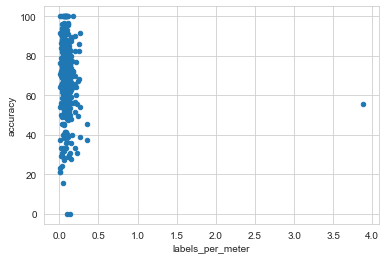

In [95]:
# We can use Pandas to create a scatter plot directly but hard to color by user group
ax = df_users.plot.scatter(x='labels_per_meter', y='accuracy')

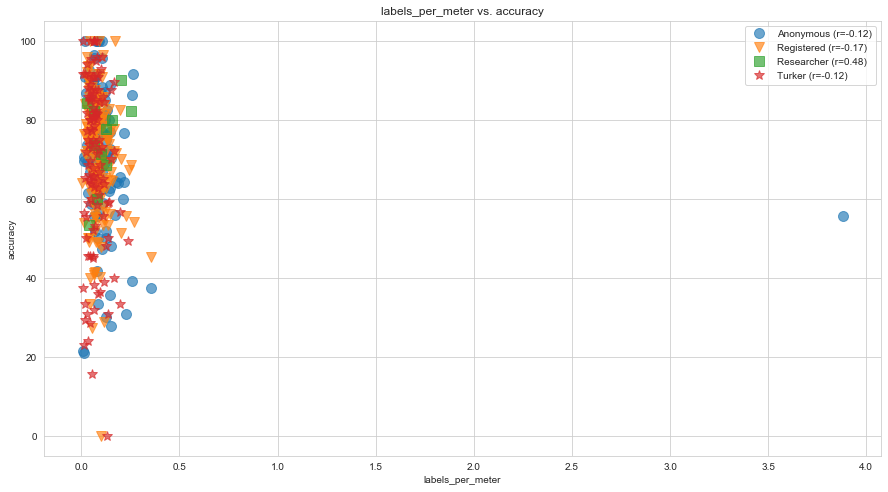

In [96]:
# So I made my own scatter plot. Let's look at the relationship between labels_per_meter and accuracy
plot_scatter(df_users, 'labels_per_meter', 'accuracy');

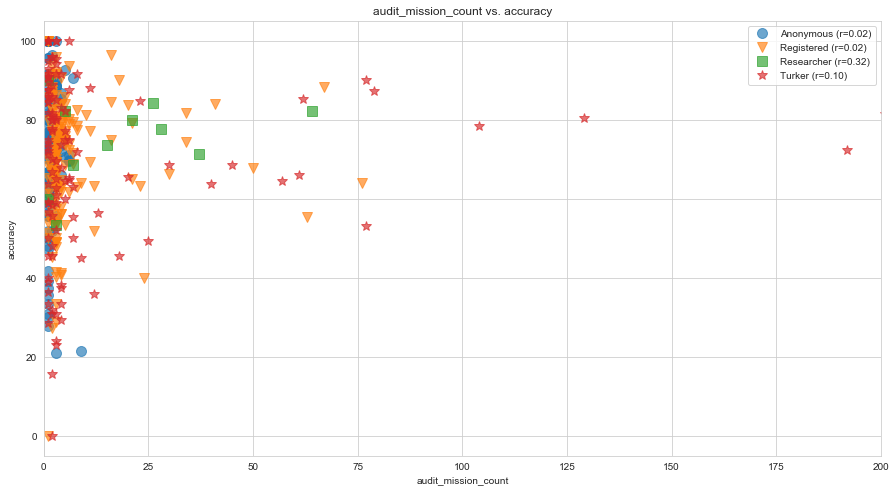

In [97]:
plot_scatter(df_users, 'audit_mission_count', 'accuracy', xlim=(0, 200));

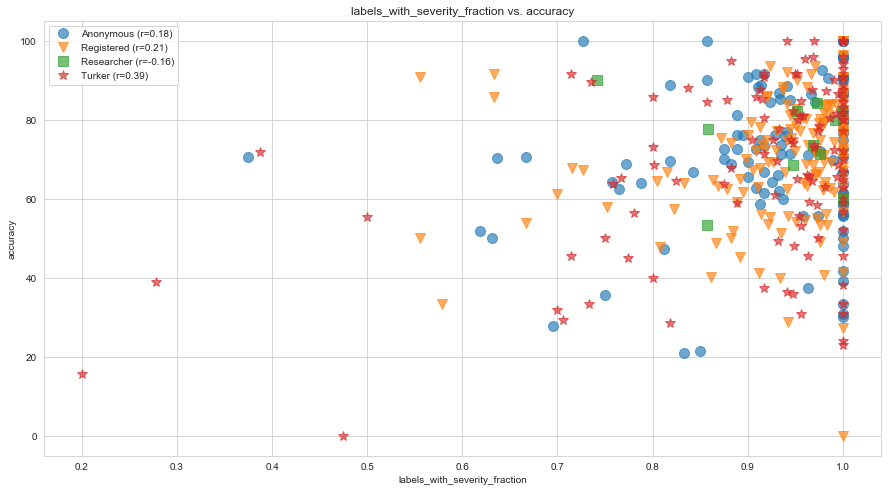

In [98]:
plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy');

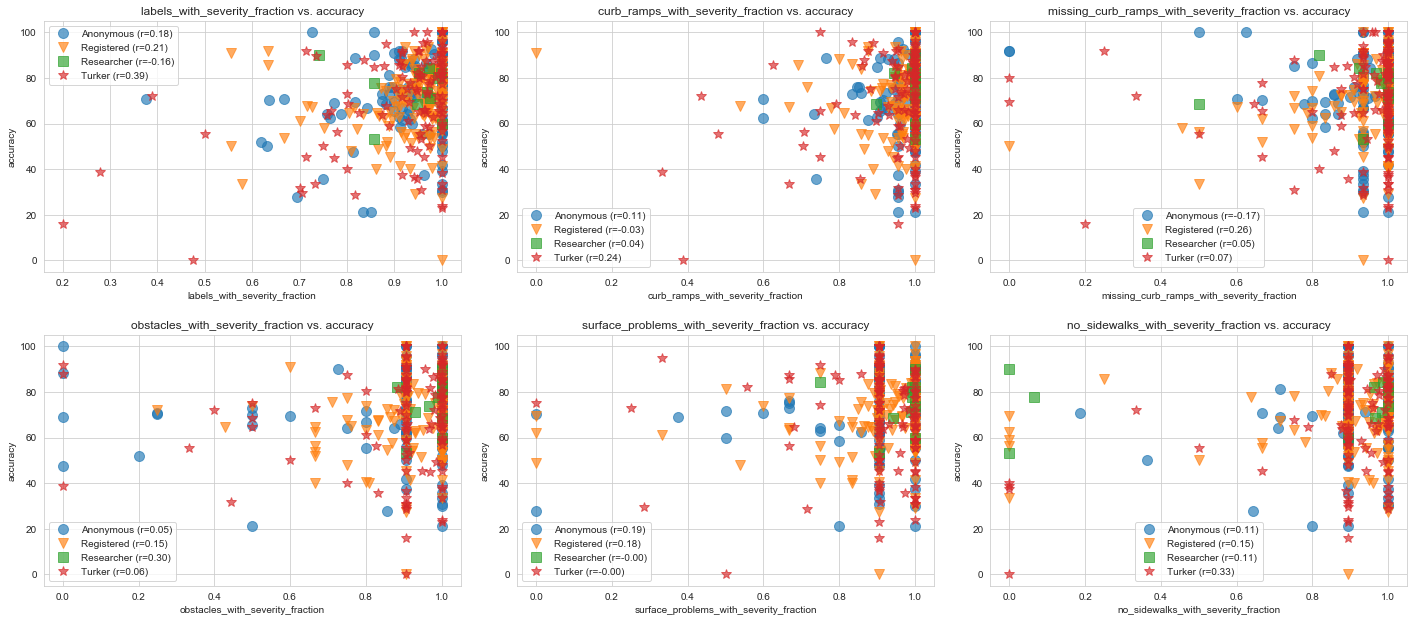

In [99]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy', ax = axes[0][0])
plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])
plt.tight_layout(pad=2)

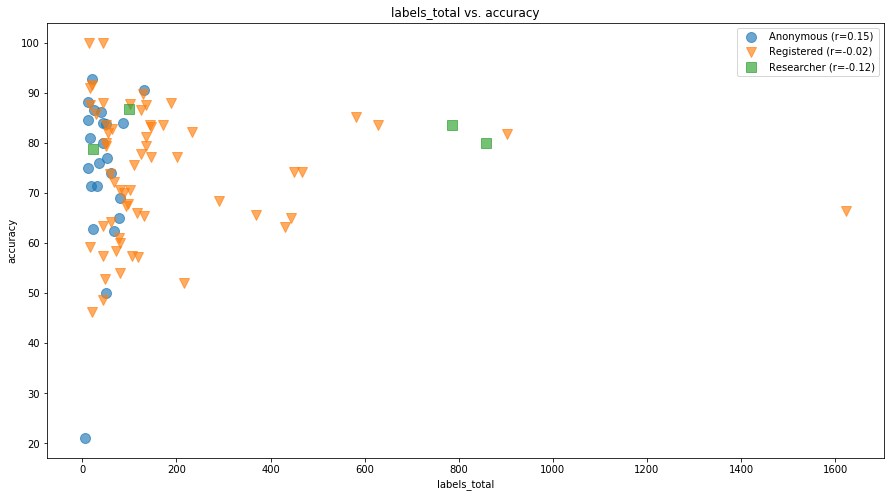

In [17]:
plot_scatter(df_users, 'labels_total', 'accuracy');

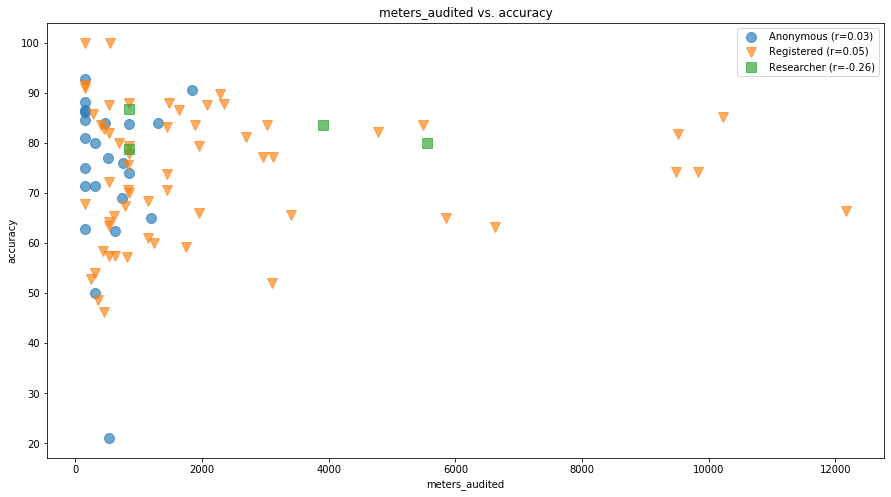

In [18]:
plot_scatter(df_users, 'meters_audited', 'accuracy');

# Accuracy as a function of role

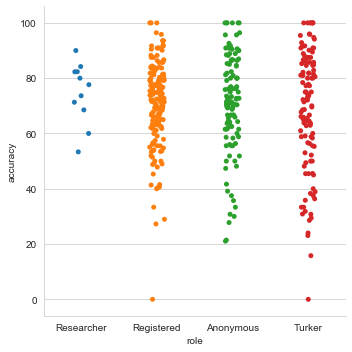

In [100]:
# from: https://seaborn.pydata.org/tutorial/categorical.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
sns.catplot(x="role", y="accuracy", jitter=True, data=df_users);

,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,112,203,3.810065e+04,2773,2895,71.321810,72.570533,18.075615
Registered,168,2417,6.589472e+05,32957,21624,70.805426,72.440780,15.246394
Researcher,11,208,5.383767e+04,4824,6182,74.843728,77.653004,10.957913
Turker,119,2616,7.488836e+05,46910,22257,69.166489,72.782765,21.656769
Total,410,5444,1.499769e+06,87464,52958,70.579140,72.727273,17.974369


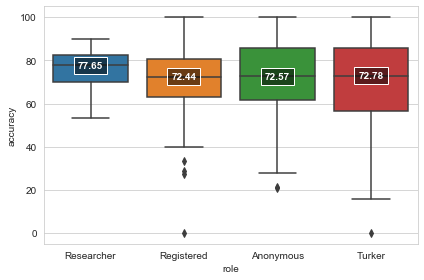

In [101]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot
sns.set_style("whitegrid")
# sns.catplot(x="role", y="accuracy", kind="box", data=df_users, height=6);
box_plot = sns.boxplot(x="role", y="accuracy", data=df_users)

# add in values
# from: https://stackoverflow.com/a/56879116
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0], 2) 

    ax.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold', 
        size=10, color='w', bbox=dict(facecolor='#00000088'))

box_plot.figure.tight_layout()
display_overview(df_users)

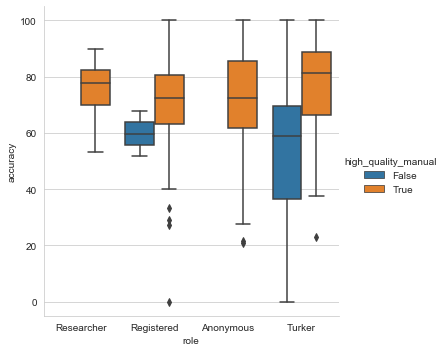

In [102]:
sns.catplot(x="role", y="accuracy", kind="box", hue='high_quality_manual', data=df_users);

## Histograms

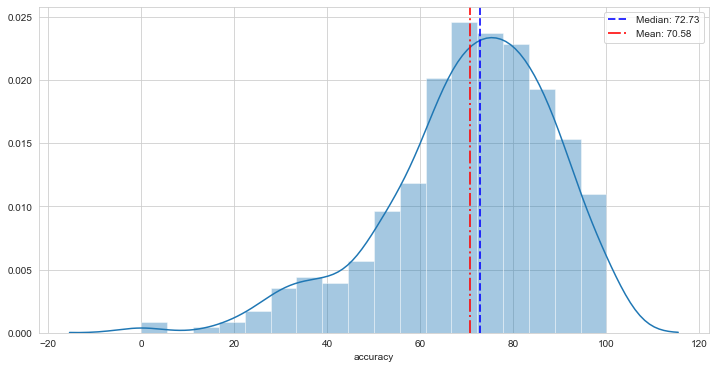

In [118]:
import seaborn as sns, numpy as np

plt.figure(figsize=(12, 6))
ax = sns.distplot(df_users['accuracy'])
plt.axvline(np.median(df_users['accuracy']), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users['accuracy']):0.2f}", linewidth=2, alpha=0.8)
plt.axvline(np.mean(df_users['accuracy']), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users['accuracy']):0.2f}", linewidth=2, alpha=0.8)
plt.legend();

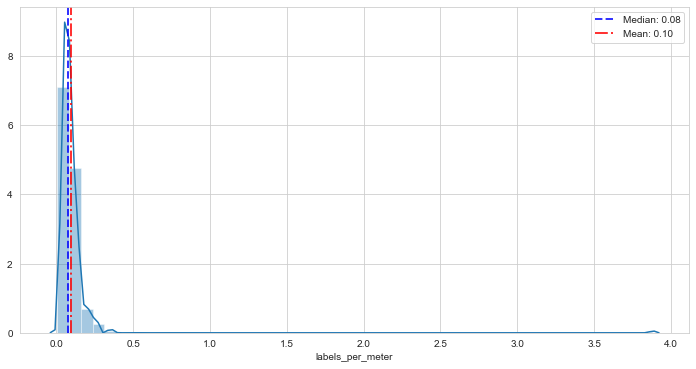

In [121]:
plt.figure(figsize=(12, 6))
col = 'labels_per_meter'
ax = sns.distplot(df_users[col])
plt.axvline(np.median(df_users[col]), color='b', linestyle='--', 
            label=f"Median: {np.median(df_users[col]):0.2f}", linewidth=2, alpha=0.8)
plt.axvline(np.mean(df_users[col]), color='r', linestyle='-.', 
            label=f"Mean: {np.mean(df_users[col]):0.2f}", linewidth=2, alpha=0.8)
plt.legend();

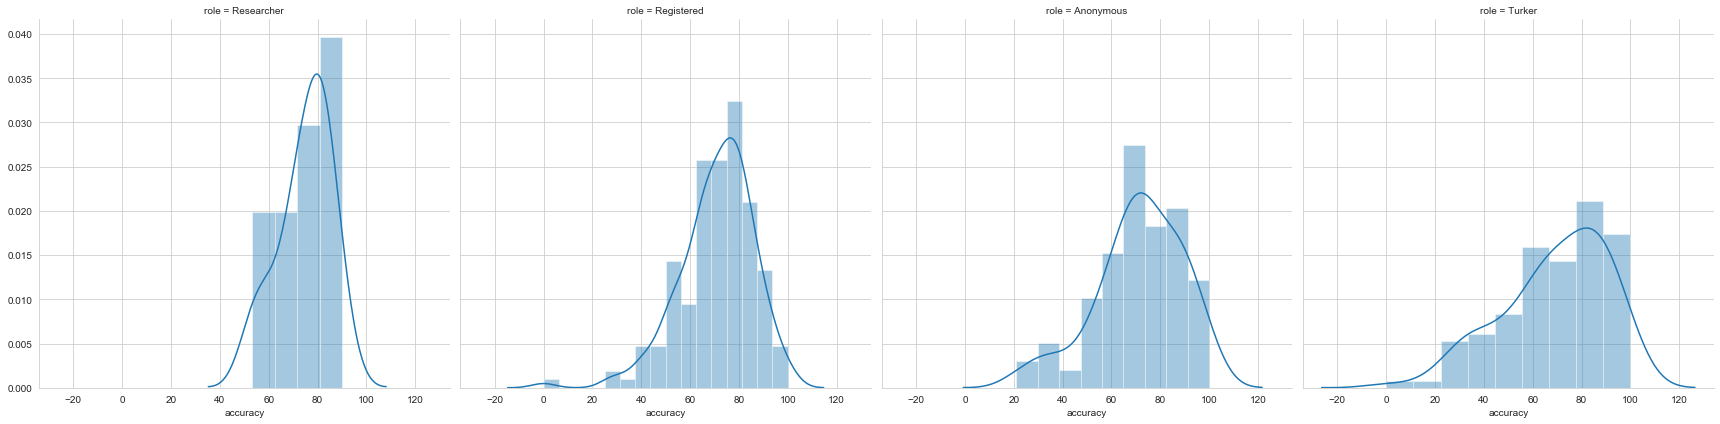

In [119]:
# https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/
g = sns.FacetGrid(df_users, row=None, col='role', height = 6)
g.map(sns.distplot, "accuracy")
plt.show()

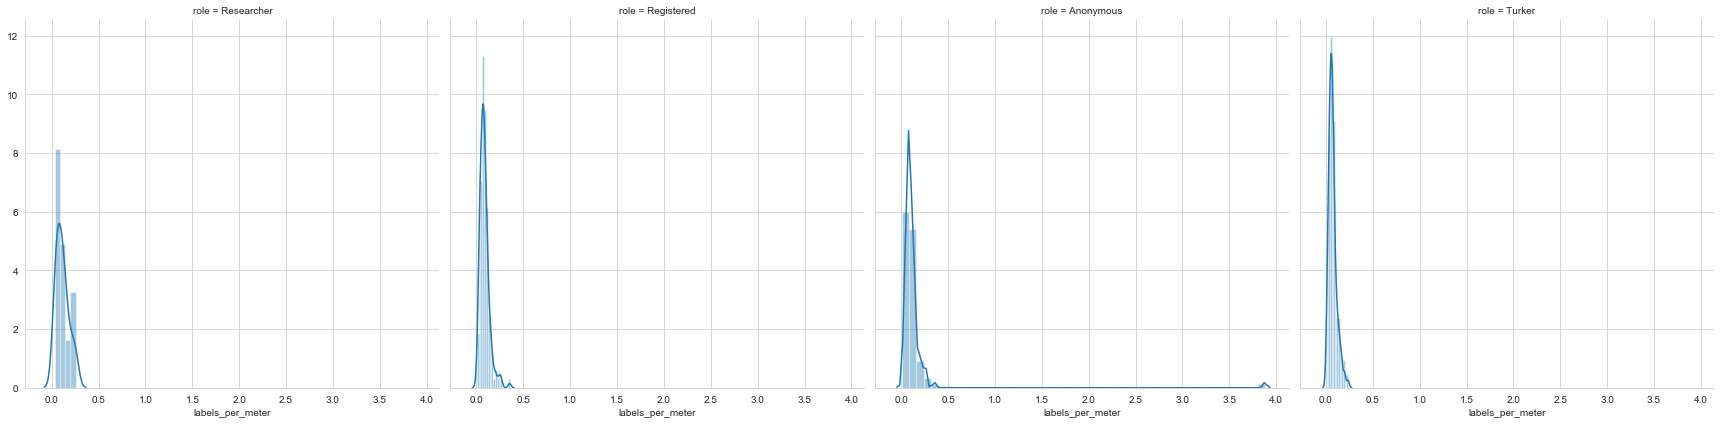

In [120]:
g = sns.FacetGrid(df_users, col='role', height = 6)
g.map(sns.distplot, "labels_per_meter")

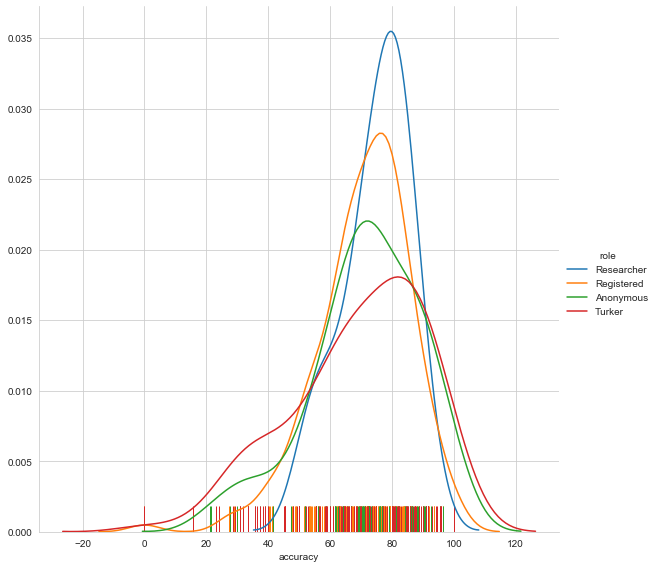

In [122]:
# fig, ax = plt.subplots(figsize=(10, 8))
g = sns.FacetGrid(df_users, hue="role", height=8)
g = g.map(sns.distplot, "accuracy",  hist=False, rug=True);
g.add_legend()

## Jointploints

C:\Users\jonfr\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


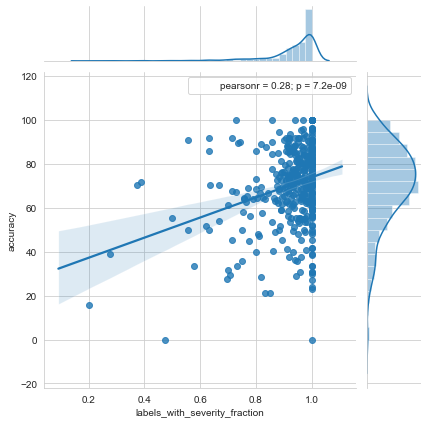

In [123]:
j = sns.jointplot(data=df_users, x='labels_with_severity_fraction', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr) # from: https://stackoverflow.com/a/52119784
plt.show()

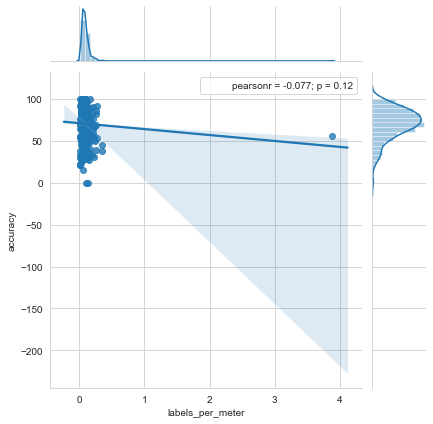

In [124]:
j = sns.jointplot(data=df_users, x='labels_per_meter', y='accuracy', kind='reg')
j.annotate(sp.stats.pearsonr)
plt.show()

# Regression predictions

In [125]:
# https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
# plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
# plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
# plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
# plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])


X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'missing_curb_ramps_with_severity_fraction',
              'obstacles_with_severity_fraction', 'surface_problems_with_severity_fraction', 
              'curb_ramps_with_severity_fraction', 'no_sidewalks_with_severity_fraction']]
y = df_users['accuracy'].values

# TODO: update this to be k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
display(coeff_df)

y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(df.sample(10))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

,Coefficient
labels_per_meter,-50.620166
labels_with_severity_fraction,75.712797
missing_curb_ramps_with_severity_fraction,-13.844346
obstacles_with_severity_fraction,-14.492156
surface_problems_with_severity_fraction,4.507342
curb_ramps_with_severity_fraction,-21.454387
no_sidewalks_with_severity_fraction,2.003178


,Actual,Predicted
28,78.395062,69.925310
3,75.352113,68.128629
39,67.673716,65.476489
78,65.000000,71.261651
66,95.833333,74.707371
57,72.075280,75.140594
65,76.086957,71.143764
27,76.744186,74.533756
53,91.666667,45.347945
72,63.636364,66.671264


Mean Absolute Error: 15.492523004844003
Root Mean Squared Error: 26.456081240283023


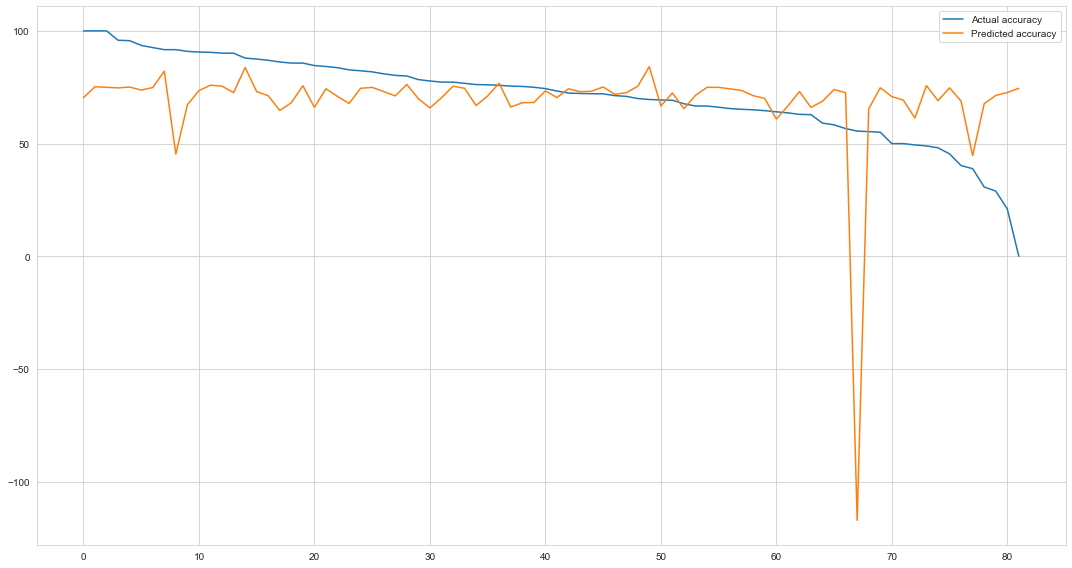

In [126]:
sorted_indices = y_test.argsort()[::-1]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(y_test[sorted_indices], label="Actual accuracy")
ax.plot(y_pred[sorted_indices], label="Predicted accuracy")
ax.legend()
fig.tight_layout()

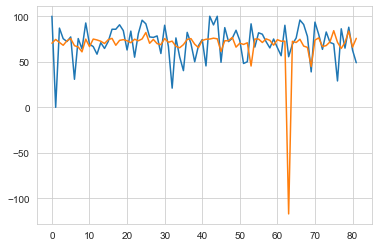

In [127]:
plt.plot(y_test)
plt.plot(y_pred)

# User classification

In [132]:
bin_labels_5 = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Very Good']
df_users['quality_5bins'] = pd.qcut(df_users['accuracy'], 5, labels=bin_labels_5)

bin_labels_3 = ['Bad', 'Neutral', 'Good']
df_users['quality_3bins'] = pd.qcut(df_users['accuracy'], 3, labels=bin_labels_3)

df_users.head()

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction,quality_5bins,bin_labels_3,quality_3bins
13,2726c177-f8f0-44c4-aad4-bc2055099c2f,Researcher,421,73.634204,15,3,True,3374.588860,223,216,...,0.066082,0.968610,1.000000,1.0,0.966667,1.000000,1.000000,Neutral,Neutral,Neutral
20,d9278200-e9a1-4b3d-ad62-5f91d4ec67e1,Registered,29,75.862069,5,3,True,1110.994898,24,24,...,0.021602,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,Neutral,Neutral,Neutral
13,33fa5c91-b1a3-4c11-985d-d336a2612394,Anonymous,35,71.428571,1,1,True,152.399994,18,17,...,0.118110,0.944444,1.000000,0.9,0.904808,0.905913,0.894552,Neutral,Neutral,Neutral
20,41ff3013-b756-4bc8-9c74-dcfa74e64659,Registered,30,63.333333,3,4,True,533.399994,45,45,...,0.084364,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,Bad,Bad,Bad
25,4e8e59ae-b749-4a27-9283-05d9e0d49434,Registered,63,77.777778,4,0,True,838.199982,125,118,...,0.149129,0.944000,0.976744,1.0,1.000000,1.000000,0.636364,Good,Neutral,Neutral


In [134]:
df_users.groupby('quality_3bins').describe()

validations_received_count                                      \
                                   count        mean         std   min   25%   
quality_3bins                                                                  
Bad                                137.0   76.751825  170.858721  11.0  18.0   
Neutral                            141.0  168.049645  412.948619  11.0  23.0   
Good                               132.0  142.030303  399.523112  11.0  14.0   

                                   accuracy             ...  \
                50%    75%     max    count       mean  ...   
quality_3bins                                           ...   
Bad            30.0   68.0  1519.0    137.0  50.507683  ...   
Neutral        42.0  102.0  2785.0    141.0  73.111286  ...   
Good           23.0   56.5  2921.0    132.0  88.706088  ...   

              surface_problems_with_severity_fraction       \
                                                  75%  max   
quality_3bins                                                
Bad                                               1.0  1.0   
Neutral                                           1.0  1.0   
Good                                              1.0  1.0   

              no_sidewalks_with_severity_fraction                           \
                                            count      mean       std  min   
quality_3bins                                                                
Bad                                         137.0  0.851576  0.247911  0.0   
Neutral                                     141.0  0.911000  0.150522  0.0   
Good                                        132.0  0.921587  0.114386  0.0   

                                             
                    25%       50%  75%  max  
quality_3bins                                
Bad            0.894552  0.894552  1.0  1.0  
Neutral        0.894552  0.911111  1.0  1.0  
Good           0.894552  0.894552  1.0  1.0  

[3 rows x 192 columns]

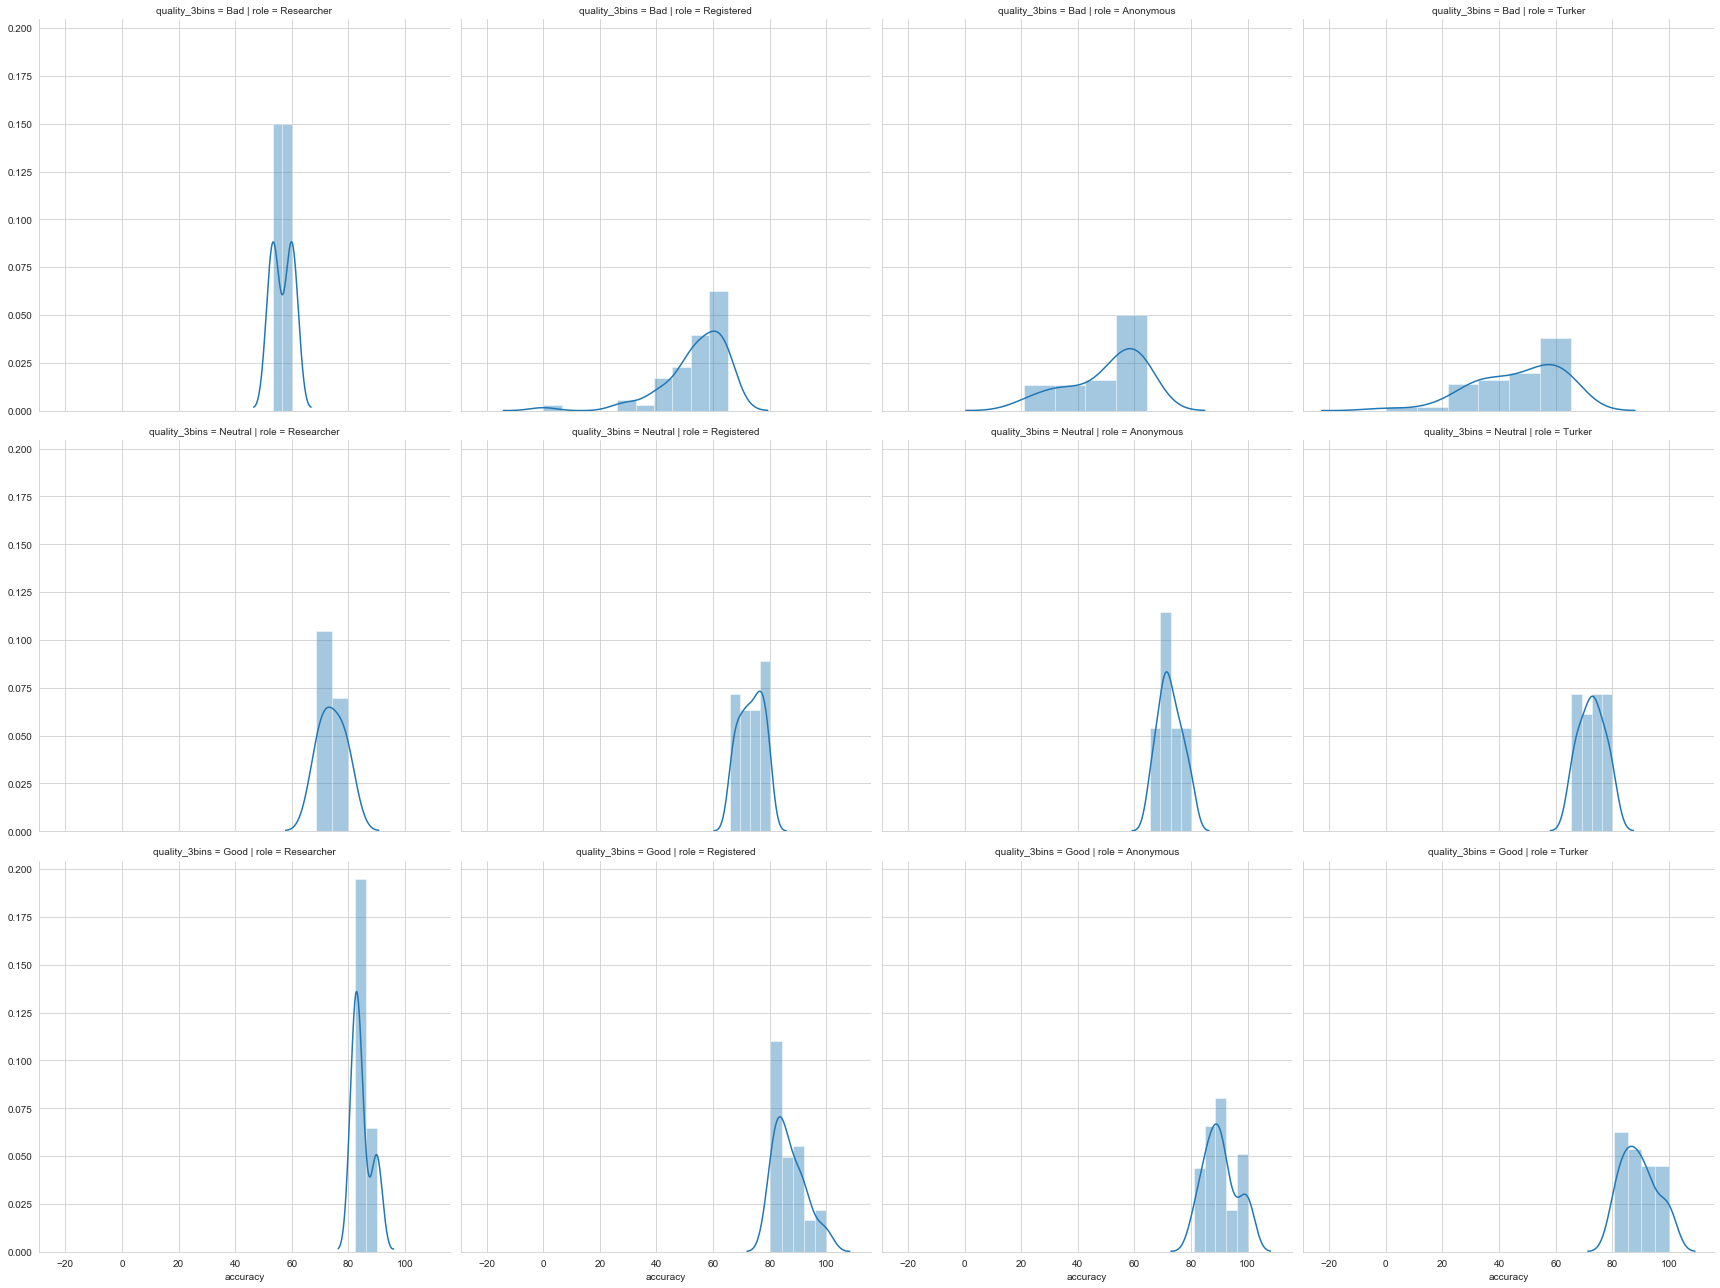

In [133]:
g = sns.FacetGrid(df_users, row='quality_3bins', col='role', height = 6)
g.map(sns.distplot, "accuracy")
plt.show()

# Sandbox

## Pairwise correlations

Text(0.5, 1, 'Pairwise correlation of input features')

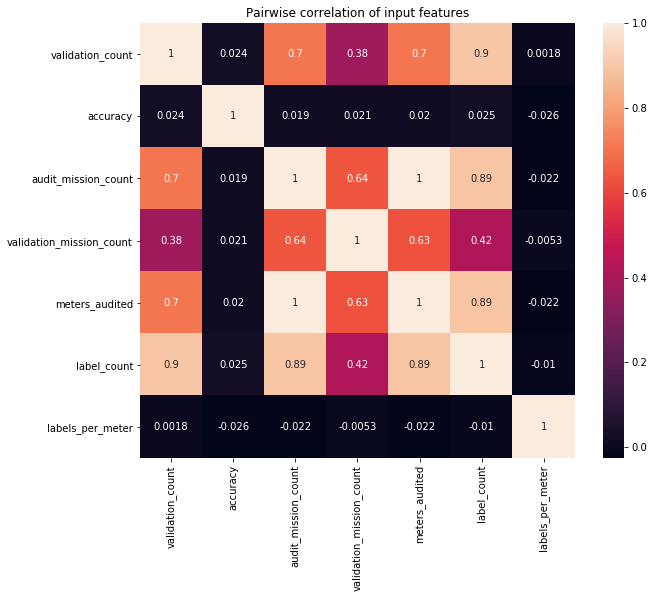

In [118]:
pairwise_corr = df_users.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_corr, square=True, annot=True)
plt.title(f"Pairwise correlation of input features")

## Pairplots

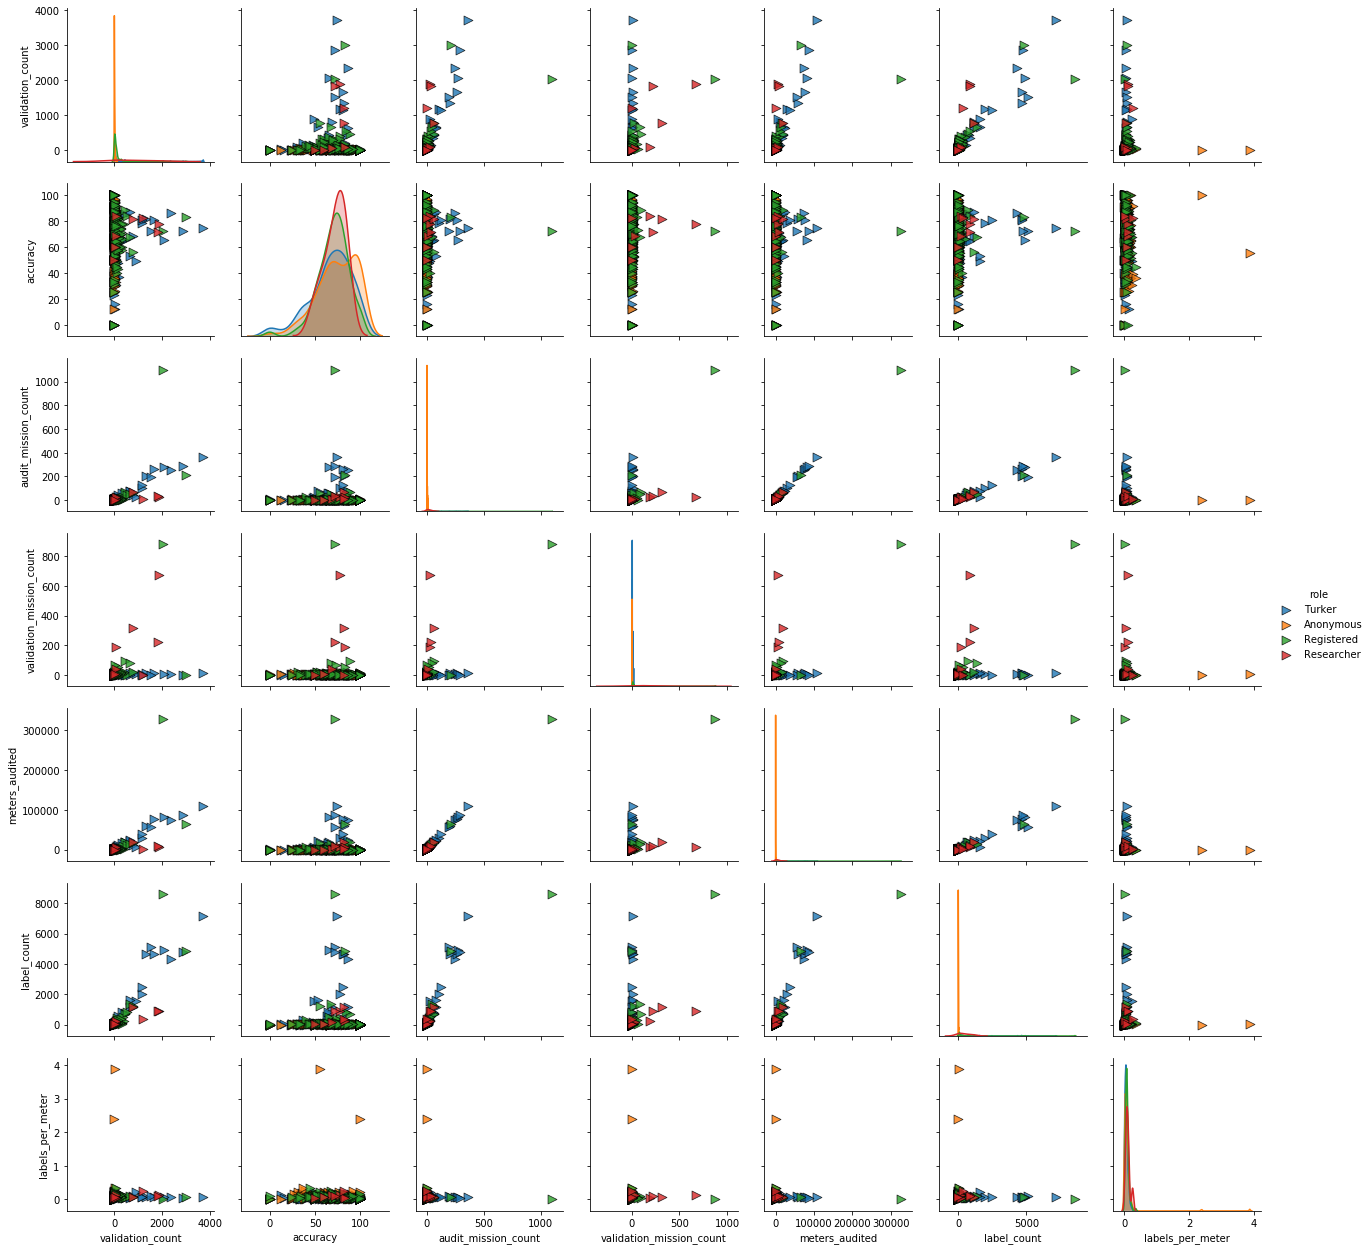

In [122]:
# Create the pairplot (this might take a bit of time)
markers = plot_markers[4]
sns.pairplot(df_users, hue="role", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);